# 📚 Book Rating Clustering - Initial EDA + Baseline Model



### Executive Summary
This project investigates how user behavior around book ratings can be used to uncover distinct groups of readers using unsupervised learning. The focus is on clustering users into interpretable segments to enable more personalized book recommendations and strategic content targeting.

### Rationale
**Why this matters**: Understanding user behavior is critical for strategic decision-making in digital content platforms. By clustering users with interpretable, behavior-based features, this project can uncover actionable insights. These segments can guide product development, content strategy, and marketing priorities—enabling more focused investments and personalized user experiences. Without this analysis, platforms risk missing key engagement drivers and allocating resources toward generic strategies that may not resonate.


---

### Research Question

Can we cluster users based on interpretable features extracted from their book rating behavior to uncover distinct reader segments?

**Hypothesis**: It is possible to uncover meaningful and interpretable user segments by clustering users based on book rating behavior and available profile information. These segments can reveal distinct patterns in engagement, preferences, and interest, supporting more targeted content, product, and marketing strategies.

---

### Data Sources 
The dataset is sourced from Kaggle: [Book Crossing Dataset](https://www.kaggle.com/datasets/syedjaferk/book-crossing-dataset?select=BX-Book-Ratings.csv). Collected by Cai-Nicolas Ziegler in a 4-week crawl (August / September 2004) from the Book-Crossing community with kind permission from Ron Hornbaker, CTO of Humankind Systems. Contains 278,858 users (anonymized but with demographic information) providing 1,149,780 ratings (explicit / implicit) about 271,379 books. It contains:

● BX-Users- Contains the users. Note that user IDs (User-ID) have been anonymized and map to integers. Age and location is provided if available.

● BX-Books - Identified by their respective ISBN. Book metadata, such as Book-Title, Book-Author, Year-Of-Publication, Publisher, were obtained from Amazon Web Services. 

● BX-Book-Ratings - Contains the book rating information (User-ID, ISBN, Rating). 

Additionally, I am using data from [Simple Maps, US Cities Data](https://https://simplemaps.com/data/us-cities) to get lat and lng for US cities.  Manual google search for high volume cities not included in the Simple Maps data to create [loc_lat_lng.csv]("data/loc_lat_lng.csv")



---
### Methodology
The project follows a streamlined version of CRISP-DM for unsupervised learning:

**1. Business Understanding**  
Develop reader segments that reflect different behaviors and engagement patterns using clustering techniques. The outcome will support personalization and strategic content decisions, particularly in environments with limited demographic data.

**2. Data Understanding**  
Integrate the 3 data files and explore and assess the structure, completeness, and behavioral richness of the Book-Crossing dataset. This includes rating patterns, book metadata (titles, authors, publishers, year), and user demographics. 

**3. Data Preparation**  
- Clean and structure the raw dataset
- Parse and standardize book metadata (author, publisher, pub year)
- Parse location into city, region, country (when available)
- Apply TF-IDF to title words (Book_titles excluding stop words) with N-grams = 1,2
- Engineer user-level features (examples below):
  - Reading and rating counts
  - Publication era preferences
  - Title-word extraction:
    - `interest_title_words` (all books)
    - `fav_title_words` (books rated > 7)
  - Favorite author/publisher (mode or frequency)
- Optionally split the dataset (e.g., 80/20) to reserve a portion for future prediction experiments.


**4. Modeling**  
- Use clustering techniques (ie KMeans) to cluster users based on behavioral and demographic features
- Apply dimensionality reduction (PCA) for visualization only
- Evaluate interpretability and separation of clusters


**5. Evaluation**  
- Silhouette Score to guide K choice
- Distribution analysis of users across clusters
- Interpretability based on key features per segment


**6. Deployment / Insights**  
- Assign persona labels to users
- Investigate implications for:
  - Personalized book recommendations
  - Thematic or genre-based content promotions
  - Identifying underserved reader personas


**7. Tools**
- **Data Wrangling**: `pandas`, `numpy`, `os`, `zipfile`  
- **Visualization**: `matplotlib.pyplot`, `seaborn`  
- **Text Processing**: `re`, `collections.Counter`, `nltk` (`stopwords`, `WordNetLemmatizer`)  
- **Modeling & Feature Engineering (scikit-learn)**:  
  - Preprocessing: `StandardScaler`, `OneHotEncoder`, `TfidfVectorizer`  
  - Workflow: `Pipeline`, `ColumnTransformer`, `train_test_split`  
  - Clustering & Evaluation: `KMeans`, `PCA`, `silhouette_score`

---

##  Data Overview & Cleaning

### Library Imports

In [2603]:

import pandas as pd
import numpy as np
import zipfile
import os
import seaborn as sns
import matplotlib.pyplot as plt  

import re
from collections import Counter
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score


### NLTK Downloads as needed

In [2605]:
# UNCOMMENT BELOW IF NOT ALREADY DOWNLOADED
# # Download once if not already available 
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

# # Initialize stopwords and lemmatizer
# stop_words = set(stopwords.words('english'))
# lemmatizer = WordNetLemmatizer()

### Load, Preview and Merge the Dataset

In [2607]:

# Base path to the data folder
data_dir = 'data'

# Load Users.csv directly
users_df = pd.read_csv('data/BX-Users.csv', encoding='latin-1', sep=';', on_bad_lines='skip', dtype={'User-ID': str})

# Extract and load BX-Book-Ratings.csv
with zipfile.ZipFile(os.path.join(data_dir, 'BX-Book-Ratings.csv.zip'), 'r') as zip_ref:
    zip_ref.extractall(data_dir)

ratings_df = pd.read_csv(os.path.join(data_dir, 'BX-Book-Ratings.csv'), encoding='latin-1', sep=';', on_bad_lines='skip',dtype={'ISBN': str})

# Extract and load BX-Books.csv
with zipfile.ZipFile(os.path.join(data_dir, 'BX-Books.csv.zip'), 'r') as zip_ref:
    zip_ref.extractall(data_dir)

books_df = pd.read_csv(os.path.join(data_dir, 'BX-Books.csv'), encoding='latin-1', sep=';', on_bad_lines='skip',
    usecols=['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'Image-URL-S'], dtype= str)

# rename column to something friendlier
books_df.rename(columns={'Image-URL-S': 'ImageURL'}, inplace=True)

# Confirm loading
print("Users:", users_df.shape)
print("Ratings:", ratings_df.shape)
print("Books:", books_df.shape)


Users: (278858, 3)
Ratings: (1149780, 3)
Books: (271379, 6)



#### Explore user_df

In [2609]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  object 
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), object(2)
memory usage: 6.4+ MB


In [2610]:
# Convert User-ID to integer
users_df['User-ID'] = pd.to_numeric(users_df['User-ID'], errors='coerce').astype('Int64')

# Convert Age to numeric (preserve NaNs), then optionally to Int64
users_df['Age'] = pd.to_numeric(users_df['Age'], errors='coerce').astype('Int64')

# Check results
users_df.describe()


,User-ID,Age
count,278858.0,168096.0
mean,139429.5,34.751434
std,80499.51502,14.428097
min,1.0,0.0
25%,69715.25,24.0
50%,139429.5,32.0
75%,209143.75,44.0
max,278858.0,244.0



#### Explore book_df

In [2612]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271379 entries, 0 to 271378
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271379 non-null  object
 1   Book-Title           271379 non-null  object
 2   Book-Author          271377 non-null  object
 3   Year-Of-Publication  271379 non-null  object
 4   Publisher            271377 non-null  object
 5   ImageURL             271379 non-null  object
dtypes: object(6)
memory usage: 12.4+ MB


In [2613]:
# Identify non-numeric values (excluding nulls)
non_numeric_mask = pd.to_numeric(books_df['Year-Of-Publication'], errors='coerce').isna() & books_df['Year-Of-Publication'].notna()
non_numeric_years = books_df[non_numeric_mask]

# Show total count
print(f"Total non-null, non-numeric 'Year-Of-Publication' values: {len(non_numeric_years)}")


# Show sample of affected rows
print("\nSample rows with non-numeric years:")
print(non_numeric_years[['ISBN', 'Book-Title', 'Book-Author','Year-Of-Publication']].head(2))

Total non-null, non-numeric 'Year-Of-Publication' values: 22

Sample rows with non-numeric years:
             ISBN  \
6450   0735201994   
43665  0330482750   

                                                                                     Book-Title  \
6450   Peterman Rides Again: Adventures Continue with the Real \J. Peterman\" Through Life &amp   
43665                                            Three Novels: \A Strange and Sublime Address\"   

                  Book-Author Year-Of-Publication  
6450    the Catalog Business"       John Peterman  
43665      \"Afternoon Raag\"   \"Freedom Song\""  


In [2614]:

# Convert to numeric, invalid entries become NaN
books_df['Year-Of-Publication'] = pd.to_numeric(books_df['Year-Of-Publication'], errors='coerce')

# Convert and store in 'Pub_Year'
books_df['Pub_Year'] = books_df['Year-Of-Publication'].astype('Int64')

# Drop the original column
books_df = books_df.drop(columns=['Year-Of-Publication'])


In [2615]:
books_df.describe()

,Pub_Year
count,271357.0
mean,1959.760817
std,257.994226
min,0.0
25%,1989.0
50%,1995.0
75%,2000.0
max,2050.0


In [2616]:
# Filter books with Pub_Year > 2004 (data was crawled in Aug/Sept 2004)
future_books = books_df[books_df['Pub_Year'] > 2004]

# Count how many
print(f"Books with Pub_Year > 2004: {len(future_books)}")

# Preview a few rows
future_books[['ISBN', 'Book-Title', 'Pub_Year']].head()


Books with Pub_Year > 2004: 72


,ISBN,Book-Title,Pub_Year
3541,0140124373,Red Dwarf,2005
12783,0380816792,A Rose in Winter,2011
26167,006272004X,The Astrologer's Handbook,2005
30011,068160204X,The Royals,2020
37488,0671746103,MY TEACHER FRIED MY BRAINS (RACK SIZE) (MY TEACHER BOOKS),2030



#### Explore ratings_df

In [2618]:
ratings_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB



#### Merge the data

In [2620]:
# Join Ratings + Books on ISBN
ratings_books_df = pd.merge(ratings_df, books_df, on='ISBN', how='inner')

# Join that result with Users on User-ID
full_df = pd.merge(ratings_books_df, users_df, on='User-ID', how='inner')
full_df.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Publisher,ImageURL,Pub_Year,Location,Age
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,Ballantine Books,http://images.amazon.com/images/P/034545104X.01.THUMBZZZ.jpg,2002,"tyler, texas, usa",<NA>
1,276726,0155061224,5,Rites of Passage,Judith Rae,Heinle,http://images.amazon.com/images/P/0155061224.01.THUMBZZZ.jpg,2001,"seattle, washington, usa",<NA>
2,276727,0446520802,0,The Notebook,Nicholas Sparks,Warner Books,http://images.amazon.com/images/P/0446520802.01.THUMBZZZ.jpg,1996,"h, new south wales, australia",16
3,276729,052165615X,3,Help!: Level 1,Philip Prowse,Cambridge University Press,http://images.amazon.com/images/P/052165615X.01.THUMBZZZ.jpg,1999,"rijeka, n/a, croatia",16
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge English Readers),Sue Leather,Cambridge University Press,http://images.amazon.com/images/P/0521795028.01.THUMBZZZ.jpg,2001,"rijeka, n/a, croatia",16


### Remove Duplicates and Identify Missing Data

In [2622]:
# Check for duplicate records

print("\nNumber of Duplicate Records:",full_df.duplicated(subset=['User-ID', 'ISBN']).sum())


Number of Duplicate Records: 0


In [2623]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1031175 entries, 0 to 1031174
Data columns (total 10 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1031175 non-null  int64 
 1   ISBN         1031175 non-null  object
 2   Book-Rating  1031175 non-null  int64 
 3   Book-Title   1031175 non-null  object
 4   Book-Author  1031173 non-null  object
 5   Publisher    1031173 non-null  object
 6   ImageURL     1031175 non-null  object
 7   Pub_Year     1031132 non-null  Int64 
 8   Location     1031175 non-null  object
 9   Age          753330 non-null   Int64 
dtypes: Int64(2), int64(2), object(6)
memory usage: 80.6+ MB


In [2624]:
full_df.describe()

,User-ID,Book-Rating,Pub_Year,Age
count,1.031175e+06,1.031175e+06,1031132.0,753330.0
mean,1.405944e+05,2.839022e+00,1968.194915,37.397719
std,8.052444e+04,3.854149e+00,231.101484,14.098189
min,2.000000e+00,0.000000e+00,0.0,0.0
25%,7.041500e+04,0.000000e+00,1992.0,28.0
50%,1.412100e+05,0.000000e+00,1997.0,35.0
75%,2.114260e+05,7.000000e+00,2001.0,45.0
max,2.788540e+05,1.000000e+01,2050.0,244.0


In [2625]:
print("\nDescriptive Statistics of Categorical Variables")
full_df.describe(include=['object', 'category'])


Descriptive Statistics of Categorical Variables


,ISBN,Book-Title,Book-Author,Publisher,ImageURL,Location
count,1031175,1031175,1031173,1031173,1031175,1031175
unique,270170,241090,101606,16746,269861,22480
top,0971880107,Wild Animus,Stephen King,Ballantine Books,http://images.amazon.com/images/P/0971880107.01.THUMBZZZ.jpg,"toronto, ontario, canada"
freq,2502,2502,10053,34724,2502,14782


In [2626]:
# What data is missing?

# Identify missing (NaN) values
missing_values = full_df.isnull().sum()

# Identify zero values
zero_values = full_df.eq(0).sum()

# Combine results into a single dataframe
missing_data_summary = pd.DataFrame({
    'Missing (NaN)': missing_values,
    'Zero Values': zero_values
})
missing_data_summary

,Missing (NaN),Zero Values
User-ID,0,0
ISBN,0,0
Book-Rating,0,647323
Book-Title,0,0
Book-Author,2,0
Publisher,2,0
ImageURL,0,0
Pub_Year,43,14009
Location,0,0
Age,277845,561


In [2627]:
# Set implausible Pub_Year to NaN (data collected over 4 week period in Aug/Sept 2024)
full_df.loc[(full_df['Pub_Year'] == 0) | (full_df['Pub_Year'] > 2004), 'Pub_Year'] = pd.NA


# Fill missing book data rom other rows with the same ISBN
# Columns to fill 
cols_to_fill = ['Book-Author','Publisher', 'Pub_Year']

for col in cols_to_fill:
    # Track how many were missing before
    missing_before = full_df[col].isna().sum()
    
    # Fill missing values using groupby logic
    # Try ISBN first
    full_df[col] = full_df[col].fillna(full_df.groupby('ISBN')[col].transform('first'))

    # Then try Book-Title as a fallback
    full_df[col] = full_df[col].fillna(full_df.groupby('Book-Title')[col].transform('first'))
    
    # Track how many remain missing after
    missing_after = full_df[col].isna().sum()
    
    # Report
    print(f"{col} missing BEFORE fill: {missing_before}")
    print(f"{col} missing AFTER fill:  {missing_after}")
    print(f"{col} records filled:     {missing_before - missing_after}\n")


Book-Author missing BEFORE fill: 2
Book-Author missing AFTER fill:  2
Book-Author records filled:     0

Publisher missing BEFORE fill: 2
Publisher missing AFTER fill:  1
Publisher records filled:     1

Pub_Year missing BEFORE fill: 14257
Pub_Year missing AFTER fill:  10138
Pub_Year records filled:     4119



In [2628]:
# Identify missing (NaN) values
missing_values = full_df.isnull().sum()

# Identify zero values
zero_values = full_df.eq(0).sum()

# Combine results into a single dataframe
missing_data_summary = pd.DataFrame({
    'Missing (NaN)': missing_values,
    'Zero Values': zero_values
})
missing_data_summary

,Missing (NaN),Zero Values
User-ID,0,0
ISBN,0,0
Book-Rating,0,647323
Book-Title,0,0
Book-Author,2,0
Publisher,1,0
ImageURL,0,0
Pub_Year,10138,0
Location,0,0
Age,277845,561


## Exploratory Visualizations


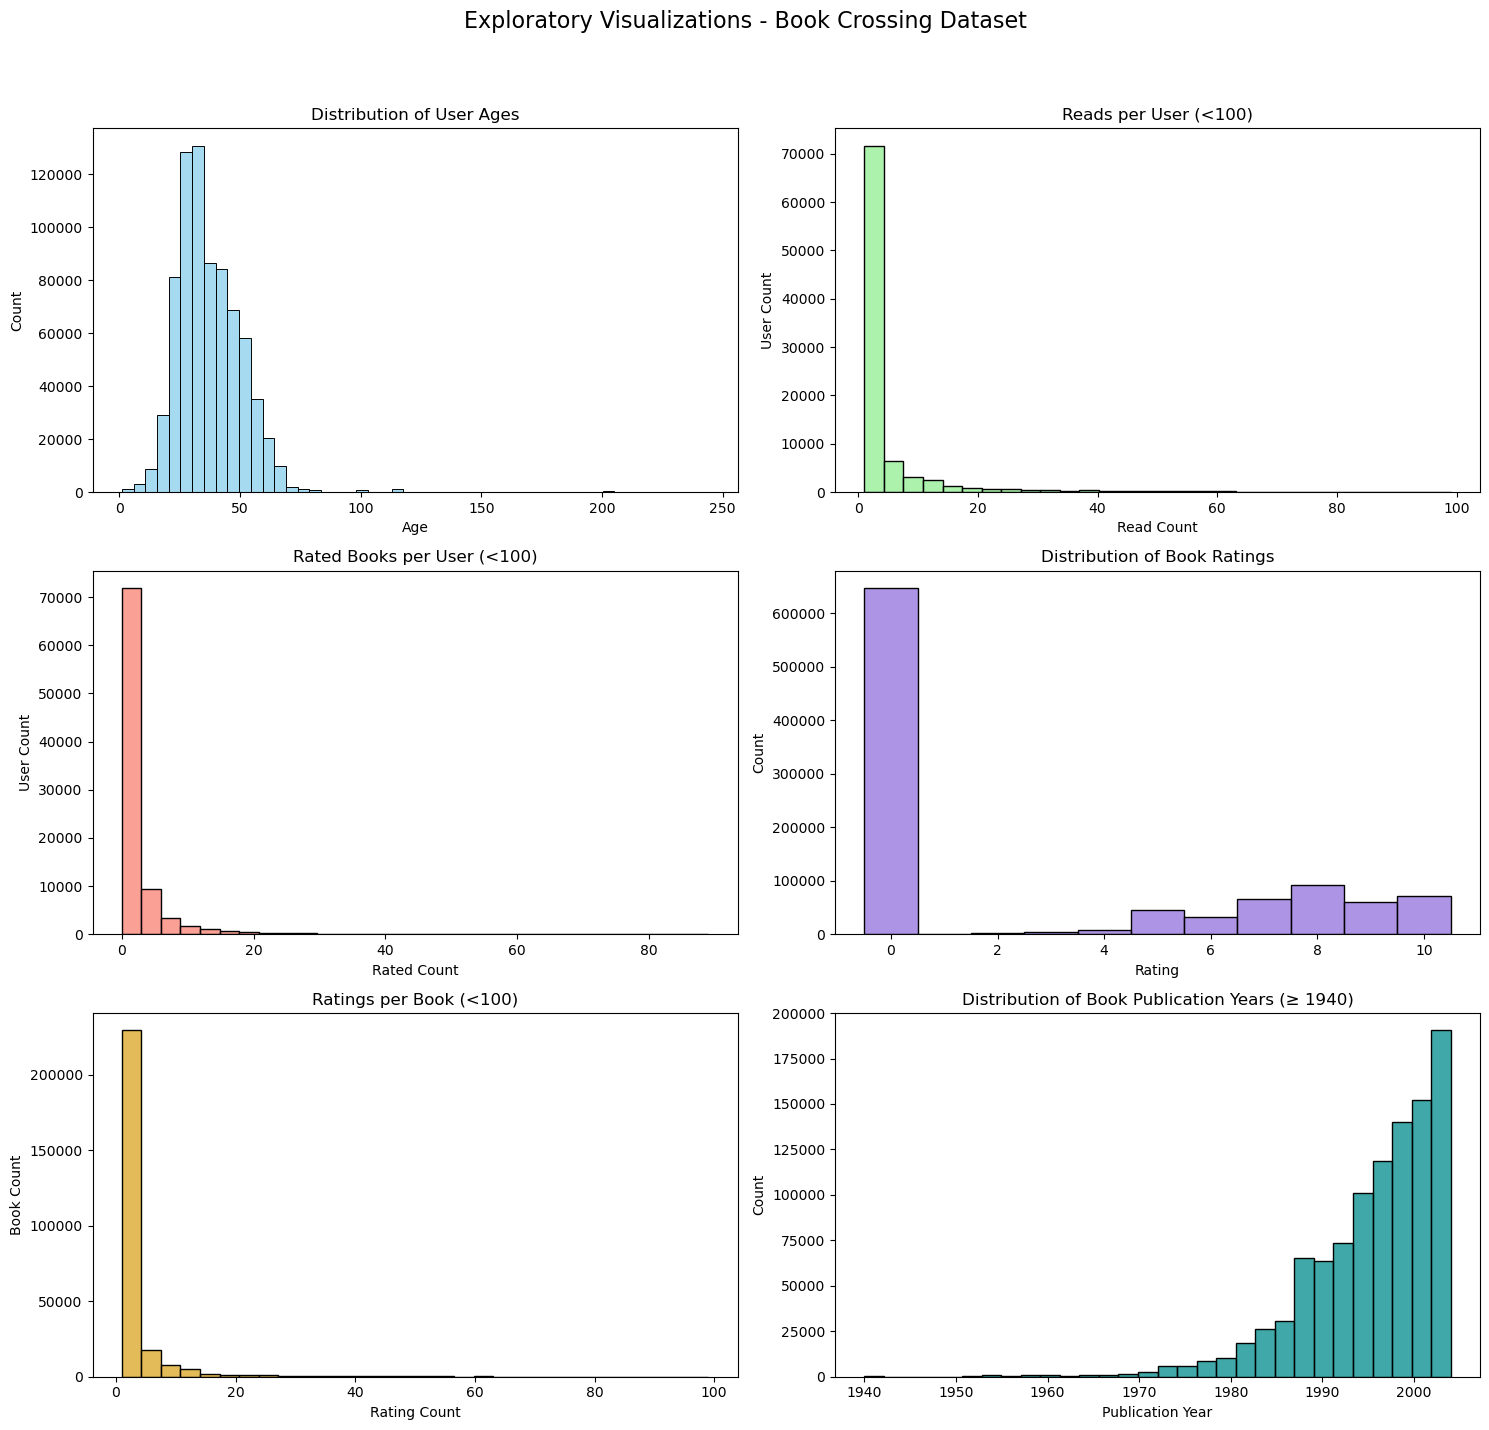

In [2630]:


# Convert relevant columns to appropriate types if necessary
full_df['Age'] = pd.to_numeric(full_df['Age'], errors='coerce')
full_df['Pub_Year'] = pd.to_numeric(full_df['Pub_Year'], errors='coerce')
full_df['Book-Rating'] = pd.to_numeric(full_df['Book-Rating'], errors='coerce')


# Filter for plotting
age_data = full_df['Age'].dropna()
age_data = age_data[age_data > 0]

user_counts = full_df.groupby('User-ID')['Book-Rating'].agg(['count', lambda x: (x > 0).sum()])
user_counts.columns = ['read_cnt', 'rated_cnt']
user_counts = user_counts[user_counts['read_cnt'] < 100]

book_counts = full_df.groupby('ISBN')['Book-Rating'].agg(['count'])
book_counts.columns = ['rating_cnt']
book_counts = book_counts[book_counts['rating_cnt'] < 100]

# Set up the figure with subplots
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
fig.suptitle('Exploratory Visualizations - Book Crossing Dataset', fontsize=16)

# Histogram: User Age
sns.histplot(age_data, bins=50, kde=False, ax=axs[0, 0], color='skyblue')
axs[0, 0].set_title('Distribution of User Ages')
axs[0, 0].set_xlabel('Age')
axs[0, 0].set_ylabel('Count')

# Histogram: Reads per User
sns.histplot(user_counts['read_cnt'], bins=30, kde=False, ax=axs[0, 1], color='lightgreen')
axs[0, 1].set_title('Reads per User (<100)')
axs[0, 1].set_xlabel('Read Count')
axs[0, 1].set_ylabel('User Count')

# Histogram: Ratings per User
sns.histplot(user_counts['rated_cnt'], bins=30, kde=False, ax=axs[1, 0], color='salmon')
axs[1, 0].set_title('Rated Books per User (<100)')
axs[1, 0].set_xlabel('Rated Count')
axs[1, 0].set_ylabel('User Count')

# Histogram: Book Ratings
sns.histplot(full_df['Book-Rating'], bins=10, discrete=True, kde=False, ax=axs[1, 1], color='mediumpurple')
axs[1, 1].set_title('Distribution of Book Ratings')
axs[1, 1].set_xlabel('Rating')
axs[1, 1].set_ylabel('Count')

# Histogram: Ratings per Book
sns.histplot(book_counts['rating_cnt'], bins=30, kde=False, ax=axs[2, 0], color='goldenrod')
axs[2, 0].set_title('Ratings per Book (<100)')
axs[2, 0].set_xlabel('Rating Count')
axs[2, 0].set_ylabel('Book Count')

# Histogram: Publication Year (1940 and later)
filtered_years = full_df['Pub_Year'].dropna()
filtered_years = filtered_years[filtered_years >= 1940]

sns.histplot(filtered_years, bins=30, kde=False, ax=axs[2, 1], color='darkcyan')
axs[2, 1].set_title('Distribution of Book Publication Years (≥ 1940)')
axs[2, 1].set_xlabel('Publication Year')
axs[2, 1].set_ylabel('Count')


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('images/exploratory_histograms.png')
plt.show()


## Feature Engineering

In [2632]:
# User Interaction Level (User level summary level is handled later)

# Load stopwords
stop_words = set(stopwords.words('english'))

# Add domain-specific words to ignore
custom_stopwords = {
    'book', 'novel', 'paperback', 'series', 'volume',
    'edition', 'harlequin','story','novella','amp'
}

# Combine the lists
all_stopwords = stop_words.union(custom_stopwords)

# Helper: Age quality score
def compute_age_quality(age):
    if pd.isna(age):
        return 0
    elif age == 0 or age > 99:
        return 0.5
    else:
        return 1

# Helper: Age group assignment
def assign_age_group(age):
    if pd.isna(age) or age == 0:
        return 'Unknown'
    elif age <= 5:
        return 'Very Young'
    elif age <= 8:
        return 'Early Reader'
    elif age <= 12:
        return 'Middle Grade'
    elif age <= 18:
        return 'Young Adult'
    elif age <= 25:
        return 'Emerging Adult'
    elif age <= 40:
        return 'Early Adult'
    elif age <= 65:
        return 'Middle Adult'
    else:
        return 'Older Adult'

# Function to extract and lemmatize words
def extract_words(title):
    if pd.isna(title):
        return []
    # Extract words 3+ characters long
    words = re.findall(r'\b[a-zA-Z]{3,}\b', title.lower())
    # Lemmatize and filter stop words
    return [
        lemmatizer.lemmatize(word)
        for word in words
        if word not in all_stopwords
    ]

# Apply engagement-level features to full_df
full_df['age_quality'] = full_df['Age'].apply(compute_age_quality)
full_df['age_group'] = full_df['Age'].apply(assign_age_group)
full_df['title_words'] = full_df['Book-Title'].apply(extract_words)

# Set Age to NaN if not between 1 and 99
full_df.loc[~full_df['Age'].between(1, 99), 'Age'] = pd.NA

# Split location string into parts
location_parts = full_df['Location'].str.split(',')

# Extract from the end (right to left)
full_df['country'] = location_parts.apply(lambda x: x[-1].strip().lower() if len(x) >= 1 else None)
full_df['region']  = location_parts.apply(lambda x: x[-2].strip().lower() if len(x) >= 2 else None)
full_df['city']    = location_parts.apply(lambda x: x[-3].strip().lower() if len(x) >= 3 else None)





In [2633]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1031175 entries, 0 to 1031174
Data columns (total 16 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   User-ID      1031175 non-null  int64  
 1   ISBN         1031175 non-null  object 
 2   Book-Rating  1031175 non-null  int64  
 3   Book-Title   1031175 non-null  object 
 4   Book-Author  1031173 non-null  object 
 5   Publisher    1031174 non-null  object 
 6   ImageURL     1031175 non-null  object 
 7   Pub_Year     1021037 non-null  Int64  
 8   Location     1031175 non-null  object 
 9   Age          749743 non-null   Int64  
 10  age_quality  1031175 non-null  float64
 11  age_group    1031175 non-null  object 
 12  title_words  1031175 non-null  object 
 13  country      1031175 non-null  object 
 14  region       1031175 non-null  object 
 15  city         1031175 non-null  object 
dtypes: Int64(2), float64(1), int64(2), object(11)
memory usage: 127.8+ MB


In [2634]:
full_df.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Publisher,ImageURL,Pub_Year,Location,Age,age_quality,age_group,title_words,country,region,city
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,Ballantine Books,http://images.amazon.com/images/P/034545104X.01.THUMBZZZ.jpg,2002,"tyler, texas, usa",<NA>,0.0,Unknown,"[flesh, tone]",usa,texas,tyler
1,276726,0155061224,5,Rites of Passage,Judith Rae,Heinle,http://images.amazon.com/images/P/0155061224.01.THUMBZZZ.jpg,2001,"seattle, washington, usa",<NA>,0.0,Unknown,"[rite, passage]",usa,washington,seattle
2,276727,0446520802,0,The Notebook,Nicholas Sparks,Warner Books,http://images.amazon.com/images/P/0446520802.01.THUMBZZZ.jpg,1996,"h, new south wales, australia",16,1.0,Young Adult,[notebook],australia,new south wales,h
3,276729,052165615X,3,Help!: Level 1,Philip Prowse,Cambridge University Press,http://images.amazon.com/images/P/052165615X.01.THUMBZZZ.jpg,1999,"rijeka, n/a, croatia",16,1.0,Young Adult,"[help, level]",croatia,n/a,rijeka
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge English Readers),Sue Leather,Cambridge University Press,http://images.amazon.com/images/P/0521795028.01.THUMBZZZ.jpg,2001,"rijeka, n/a, croatia",16,1.0,Young Adult,"[amsterdam, connection, level, cambridge, english, reader]",croatia,n/a,rijeka


In [2635]:
full_df.describe()

,User-ID,Book-Rating,Pub_Year,Age,age_quality
count,1.031175e+06,1.031175e+06,1021037.0,749743.0,1.031175e+06
mean,1.405944e+05,2.839022e+00,1995.278638,37.011112,7.288157e-01
std,8.052444e+04,3.854149e+00,7.377685,12.159039,4.435921e-01
min,2.000000e+00,0.000000e+00,1376.0,1.0,0.000000e+00
25%,7.041500e+04,0.000000e+00,1992.0,28.0,0.000000e+00
50%,1.412100e+05,0.000000e+00,1997.0,35.0,1.000000e+00
75%,2.114260e+05,7.000000e+00,2001.0,45.0,1.000000e+00
max,2.788540e+05,1.000000e+01,2004.0,99.0,1.000000e+00


In [2636]:
print("\nDescriptive Statistics of Categorical Variables")
cat_cols = ['Location', 'country', 'region', 'city']
full_df[cat_cols].describe(include='all')


Descriptive Statistics of Categorical Variables


,Location,country,region,city
count,1031175,1031175,1031175,1031175
unique,22480,288,1859,14704
top,"toronto, ontario, canada",usa,california,toronto
freq,14782,746490,107511,15122


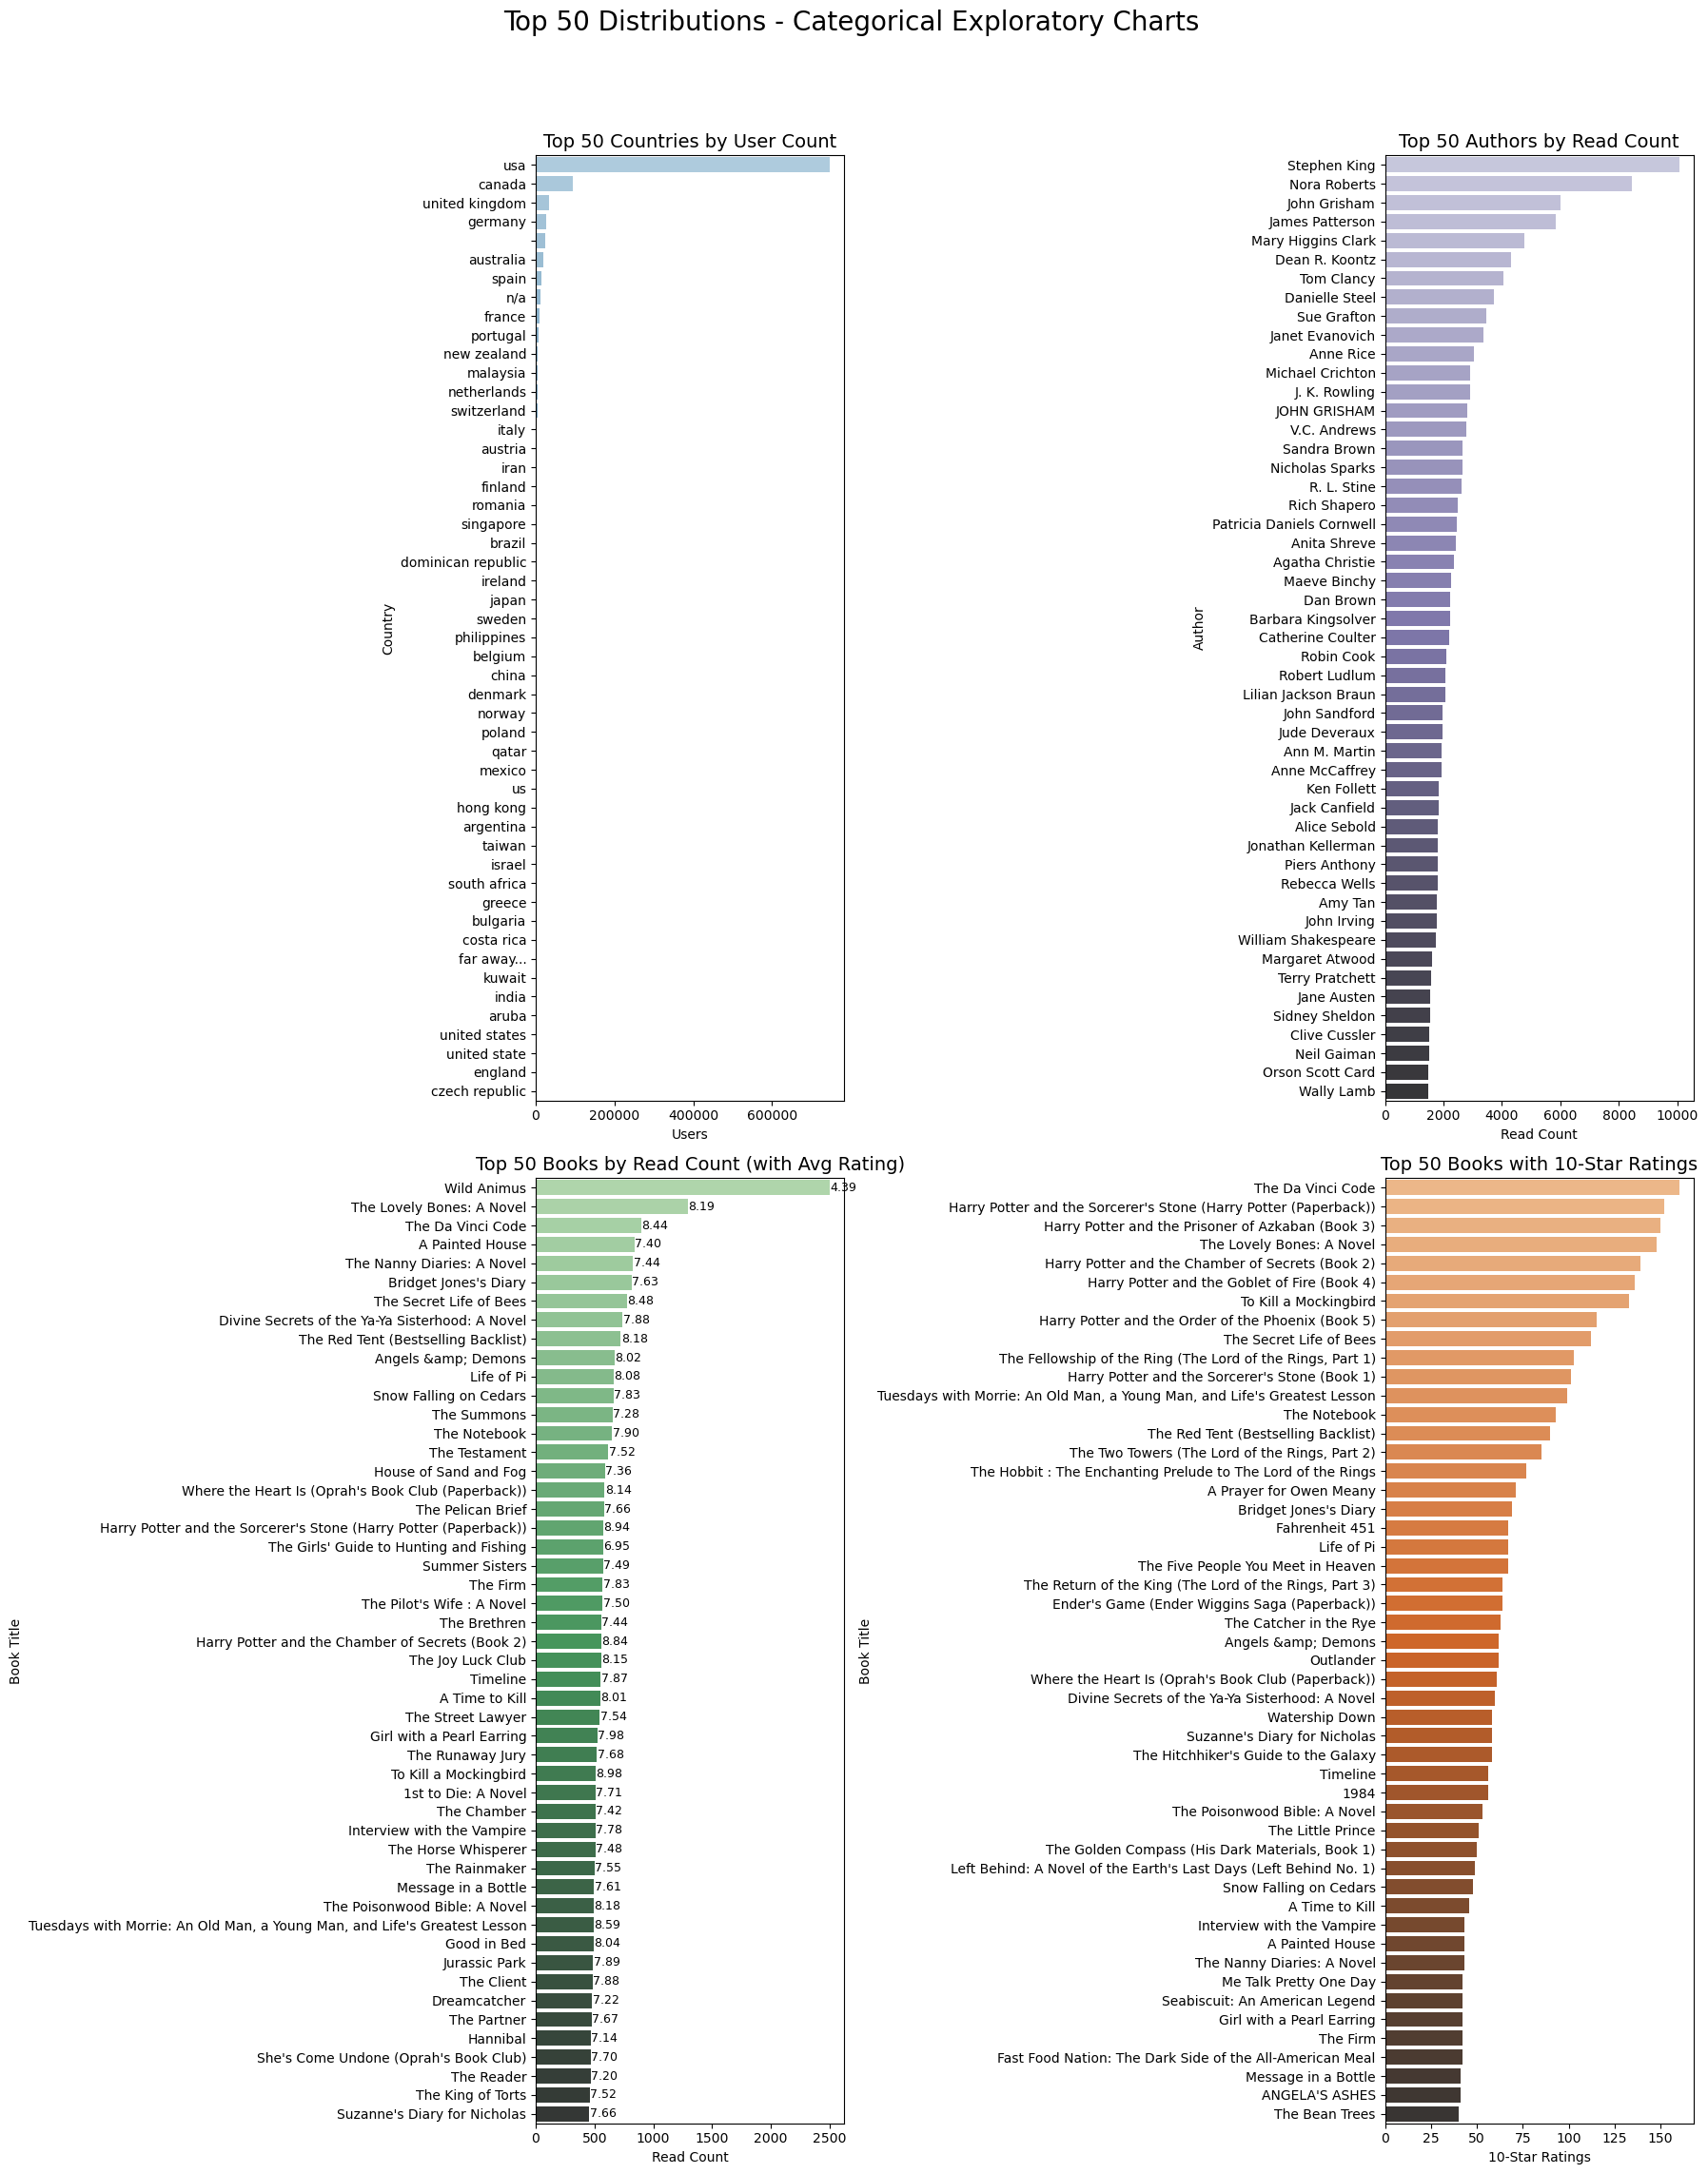

In [2637]:

# Get top 50 counts
top_countries = full_df['country'].value_counts().head(50)
top_authors = full_df['Book-Author'].value_counts().head(50)
top_books_read = full_df['Book-Title'].value_counts().head(50)
top_books_rated_10 = full_df[full_df['Book-Rating'] == 10]['Book-Title'].value_counts().head(50)

# Clean avg rating per user (ignore 0s)
nonzero_ratings = full_df[full_df['Book-Rating'] > 0]
avg_ratings_clean = nonzero_ratings.groupby('Book-Title')['Book-Rating'].mean()


# Merge read count and avg rating for top books
top_books_read_df = top_books_read.to_frame(name='Read Count')
top_books_read_df['Avg Rating'] = avg_ratings_clean.reindex(top_books_read.index)

# Set up figure with extra height for spacing
fig, axs = plt.subplots(2, 2, figsize=(18, 24))
fig.suptitle('Top 50 Distributions - Categorical Exploratory Charts', fontsize=20)

# Countries
sns.barplot(y=top_countries.index, x=top_countries.values,
            hue=top_countries.index, ax=axs[0, 0],
            palette="Blues_d", legend=False)
axs[0, 0].set_title('Top 50 Countries by User Count', fontsize=14)
axs[0, 0].set_xlabel('Users')
axs[0, 0].set_ylabel('Country')

# Authors
sns.barplot(y=top_authors.index, x=top_authors.values,
            hue=top_authors.index, ax=axs[0, 1],
            palette="Purples_d", legend=False)
axs[0, 1].set_title('Top 50 Authors by Read Count', fontsize=14)
axs[0, 1].set_xlabel('Read Count')
axs[0, 1].set_ylabel('Author')

# Most Read Books - WITH Avg Rating annotation
sns.barplot(data=top_books_read_df.reset_index(),
            y='Book-Title', x='Read Count',
            hue='Book-Title', ax=axs[1, 0],
            palette="Greens_d", legend=False)
axs[1, 0].set_title('Top 50 Books by Read Count (with Avg Rating)', fontsize=14)
axs[1, 0].set_xlabel('Read Count')
axs[1, 0].set_ylabel('Book Title')

# Annotate average ratings next to bars
for i, (count, avg) in enumerate(zip(top_books_read_df['Read Count'], top_books_read_df['Avg Rating'])):
    if pd.notna(avg):
        axs[1, 0].text(count + 3, i, f"{avg:.2f}", va='center', fontsize=9, color='black')

# Books Rated 10
sns.barplot(y=top_books_rated_10.index, x=top_books_rated_10.values,
            hue=top_books_rated_10.index, ax=axs[1, 1],
            palette="Oranges_d", legend=False)
axs[1, 1].set_title('Top 50 Books with 10-Star Ratings', fontsize=14)
axs[1, 1].set_xlabel('10-Star Ratings')
axs[1, 1].set_ylabel('Book Title')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('images/Top50Distributions.png')
plt.show()



### Eligibility Filtering

The dataset is filtered to U.S. users to reduce geographic imbalance and simplify analysis. This also enables the use of latitude and longitude for meaningful location-based clustering.

In [2639]:
# Filter for USA only
usa_df = full_df[(full_df['country'] == 'usa')].copy()

# Rename region ==> state
usa_df = usa_df.rename(columns={'region': 'state'})


print(f"Filtered dataset shape: {usa_df.shape}")
print(f"Unique users: {usa_df['User-ID'].nunique()}")


Filtered dataset shape: (746490, 16)
Unique users: 58050


In [2640]:
# Load uscities.csv from https://simplemaps.com/data/us-cities to get lat and lng 
cities_df = pd.read_csv('data/uscities.csv', encoding='latin-1', sep=',', on_bad_lines='skip')

cities_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31254 entries, 0 to 31253
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   city          31254 non-null  object 
 1   city_ascii    31254 non-null  object 
 2   state_id      31254 non-null  object 
 3   state_name    31254 non-null  object 
 4   county_fips   31254 non-null  int64  
 5   county_name   31254 non-null  object 
 6   lat           31254 non-null  float64
 7   lng           31254 non-null  float64
 8   population    31254 non-null  int64  
 9   density       31254 non-null  float64
 10  source        31254 non-null  object 
 11  military      31254 non-null  bool   
 12  incorporated  31254 non-null  bool   
 13  timezone      31254 non-null  object 
 14  ranking       31254 non-null  int64  
 15  zips          31252 non-null  object 
 16  id            31254 non-null  int64  
dtypes: bool(2), float64(3), int64(4), object(8)
memory usage: 3.6+ MB


In [2641]:
# Load manually updated file
loc_update_df = pd.read_csv("data/loc_lat_lng.csv")

loc_update_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Location     110 non-null    object 
 1   state        109 non-null    object 
 2   state_clean  109 non-null    object 
 3   city         108 non-null    object 
 4   lat          110 non-null    float64
 5   lng          110 non-null    float64
dtypes: float64(2), object(4)
memory usage: 5.3+ KB


In [2642]:
#  Standardize and clean STATE
# Step 1: Define US states and their abbreviations (standard + common variations)
us_states = {
    'alabama': 'al', 'alaska': 'ak', 'arizona': 'az', 'arkansas': 'ar', 'california': 'ca',
    'colorado': 'co', 'connecticut': 'ct', 'delaware': 'de', 'florida': 'fl', 'georgia': 'ga',
    'hawaii': 'hi', 'idaho': 'id', 'illinois': 'il', 'indiana': 'in', 'iowa': 'ia',
    'kansas': 'ks', 'kentucky': 'ky', 'louisiana': 'la', 'maine': 'me', 'maryland': 'md',
    'massachusetts': 'ma', 'michigan': 'mi', 'minnesota': 'mn', 'mississippi': 'ms', 'missouri': 'mo',
    'montana': 'mt', 'nebraska': 'ne', 'nevada': 'nv', 'new hampshire': 'nh', 'new jersey': 'nj',
    'new mexico': 'nm', 'new york': 'ny', 'north carolina': 'nc', 'north dakota': 'nd',
    'ohio': 'oh', 'oklahoma': 'ok', 'oregon': 'or', 'pennsylvania': 'pa', 'rhode island': 'ri',
    'south carolina': 'sc', 'south dakota': 'sd', 'tennessee': 'tn', 'texas': 'tx', 'utah': 'ut',
    'vermont': 'vt', 'virginia': 'va', 'washington': 'wa', 'west virginia': 'wv',
    'wisconsin': 'wi', 'wyoming': 'wy', 'district of columbia': 'dc',
    
    # Concatenated variants
    'newyork': 'ny', 'newjersey': 'nj', 'northcarolina': 'nc', 'southcarolina': 'sc',
    'westvirginia': 'wv', 'newmexico': 'nm', 'newhampshire': 'nh', 'rhodeisland': 'ri',
    'southdakota': 'sd', 'northdakota': 'nd', 'westernpennsylvania':'pa','scarolina':'', 
    'washingtonstate':'wa', 'floridakeys':'fl', 
}



# Create reverse mapping for abbreviations
abbr_to_abbr = {abbr: abbr for abbr in us_states.values()}

# Combine into one full mapping
state_lookup = {**us_states, **abbr_to_abbr}

# Step 2: Clean and standardize state names
usa_df['state'] = usa_df['state'].str.lower().str.replace(r'[^a-z]', '', regex=True)

# Step 3: Map to standard two-letter abbreviations
usa_df['state_clean'] = usa_df['state'].map(state_lookup)

# Preview mismatches or unmapped states
unmapped_states = usa_df[usa_df['state_clean'].isna()]['state'].value_counts()
unmapped_states.head(20)


state
ap                     1044
na                      834
ae                      278
puertorico              114
moving                   83
yedor                    50
myownlittleworld         48
armedforceseurope        44
unknown                  38
virginislands            34
armedforcespacific       30
rheinlandpfalz           23
armedserviceseurope      16
tasmania                 13
michigannewjersey        12
anywhereusa              11
calabria                 11
upstatenewyork           10
midwest                   9
usa                       9
Name: count, dtype: int64

In [2643]:

# Ensure state and city names are clean and lowercase
usa_df['city'] = usa_df['city'].str.lower().str.strip()
usa_df['state_clean'] = usa_df['state_clean'].str.lower().str.strip()
cities_df['city'] = cities_df['city'].str.lower().str.strip()
cities_df['state_id'] = cities_df['state_id'].str.lower().str.strip()

# Perform merge on both city and state_id to ensure correct match
usa_df = pd.merge(
    usa_df,
    cities_df[['city', 'state_id', 'lat', 'lng']],
    left_on=['city', 'state_clean'],
    right_on=['city', 'state_id'],
    how='left'
)

# Drop the redundant right-side state_id column
usa_df.drop(columns=['state_id'], inplace=True)


# Merge directly on Location
usa_df = usa_df.merge(
    loc_update_df[['Location', 'lat', 'lng']],
    on='Location',
    how='left',
    suffixes=('', '_manual')
)

# Fill missing values from manual source only if lat/lng are NaN
usa_df['lat'] = usa_df['lat'].fillna(usa_df['lat_manual'])
usa_df['lng'] = usa_df['lng'].fillna(usa_df['lng_manual'])

# Drop temp columns
usa_df.drop(columns=['lat_manual', 'lng_manual'], inplace=True)


# Preview results
print(usa_df[['Location', 'state_clean', 'city', 'lat', 'lng']].head())


                    Location state_clean       city      lat       lng
0          tyler, texas, usa          tx      tyler  32.3184  -95.3062
1   seattle, washington, usa          wa    seattle  47.6211 -122.3244
2  torrance, california, usa          ca   torrance  33.8346 -118.3416
3       iowa city, iowa, usa          ia  iowa city  41.6559  -91.5303
4       iowa city, iowa, usa          ia  iowa city  41.6559  -91.5303


In [2644]:
usa_df.describe()

,User-ID,Book-Rating,Pub_Year,Age,age_quality,lat,lng
count,746784.000000,746784.000000,743964.0,551409.0,746784.000000,709942.000000,709942.000000
mean,141909.870344,2.700142,1995.271922,37.922656,0.740150,38.204001,-95.392477
std,80201.989242,3.825712,7.281205,12.258977,0.437541,5.679993,18.381753
min,2.000000,0.000000,1806.0,1.0,0.000000,19.486400,-166.568000
25%,72575.000000,0.000000,1992.0,29.0,0.000000,34.123400,-112.089200
50%,142524.000000,0.000000,1997.0,36.0,1.000000,38.635900,-90.199400
75%,212923.000000,7.000000,2001.0,46.0,1.000000,41.648300,-80.992100
max,278854.000000,10.000000,2004.0,99.0,1.000000,70.314800,-67.224000


In [2645]:
usa_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 746784 entries, 0 to 746783
Data columns (total 19 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   User-ID      746784 non-null  int64  
 1   ISBN         746784 non-null  object 
 2   Book-Rating  746784 non-null  int64  
 3   Book-Title   746784 non-null  object 
 4   Book-Author  746784 non-null  object 
 5   Publisher    746783 non-null  object 
 6   ImageURL     746784 non-null  object 
 7   Pub_Year     743964 non-null  Int64  
 8   Location     746784 non-null  object 
 9   Age          551409 non-null  Int64  
 10  age_quality  746784 non-null  float64
 11  age_group    746784 non-null  object 
 12  title_words  746784 non-null  object 
 13  country      746784 non-null  object 
 14  state        746784 non-null  object 
 15  city         746784 non-null  object 
 16  state_clean  743938 non-null  object 
 17  lat          709942 non-null  float64
 18  lng          709942 non-

In [2646]:
usa_df.isnull().sum()


User-ID             0
ISBN                0
Book-Rating         0
Book-Title          0
Book-Author         0
Publisher           1
ImageURL            0
Pub_Year         2820
Location            0
Age            195375
age_quality         0
age_group           0
title_words         0
country             0
state               0
city                0
state_clean      2846
lat             36842
lng             36842
dtype: int64

In [2647]:
usa_df_cleaned = usa_df.dropna()
usa_df_cleaned.shape


(525429, 19)

### Create User Level Summary Data Table

In [2649]:
# Aggregate usa_df_cleaned to user-level summary
usa_user_summary = usa_df_cleaned.groupby('User-ID').agg(
    Age=('Age', 'first'),
    age_quality=('age_quality', 'first'),
    age_group=('age_group', 'first'),   
    state=('state_clean', 'first'),
    city=('city', 'first'),
    lat=('lat', 'first'),
    lng=('lng', 'first'),
    read_cnt=('User-ID', 'count'),
    rated_cnt=('Book-Rating', lambda x: (x > 0).sum()),
    rated_high_cnt=('Book-Rating', lambda x: (x > 7).sum()),
    rated_med_cnt=('Book-Rating', lambda x: x.between(4, 7).sum()),
    rated_low_cnt=('Book-Rating', lambda x: x.between(1, 3).sum()),
    rated_average=('Book-Rating', lambda x: x[x > 0].mean() if (x > 0).any() else 0),
    author_cnt=('Book-Author', pd.Series.nunique),
    publisher_cnt=('Publisher', pd.Series.nunique),
    pub_current_cnt=('Pub_Year', lambda x: x.between(2000, 2004).sum()),
    pub_90s_cnt=('Pub_Year', lambda x: x.between(1990, 1999).sum()),
    pub_80s_cnt=('Pub_Year', lambda x: x.between(1980, 1989).sum()),
    pub_70s_cnt=('Pub_Year', lambda x: x.between(1970, 1979).sum()),
    pub_classic_cnt=('Pub_Year', lambda x: (x < 1970).sum())
).reset_index()





In [2650]:
# Adjust usa_user_summary to include additional features
# Start by setting index for joining
usa_user_summary = usa_user_summary.set_index('User-ID')

# Favorite book, author and publisher from usa_df_cleaned
mostread_book = usa_df_cleaned.groupby('User-ID')['Book-Title'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else pd.NA)
favorite_authors = usa_df_cleaned.groupby('User-ID')['Book-Author'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else pd.NA)
favorite_publishers = usa_df_cleaned.groupby('User-ID')['Publisher'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else pd.NA)

# Add these to summary
usa_user_summary['favorite_author'] = favorite_authors
usa_user_summary['mostread_book'] = mostread_book
usa_user_summary['favorite_publisher'] = favorite_publishers

# Determine favorite publication era
era_cols = ['pub_current_cnt', 'pub_90s_cnt', 'pub_80s_cnt', 'pub_70s_cnt', 'pub_classic_cnt']
era_labels = {
    'pub_current_cnt': '2000s',
    'pub_90s_cnt': '1990s',
    'pub_80s_cnt': '1980s',
    'pub_70s_cnt': '1970s',
    'pub_classic_cnt': 'Classic'
}
usa_user_summary['fav_pub_era'] = usa_user_summary[era_cols].idxmax(axis=1).map(era_labels)

# Add diversity ratios
usa_user_summary['author_diversity'] = usa_user_summary['author_cnt'] / usa_user_summary['read_cnt']
usa_user_summary['publisher_diversity'] = usa_user_summary['publisher_cnt'] / usa_user_summary['read_cnt']

# Drop redundant raw counts
usa_user_summary.drop(columns=['author_cnt', 'publisher_cnt'], inplace=True)


In [2651]:
# All titles the user interacted with (interest)
interest_title_words = usa_df_cleaned.groupby('User-ID')['title_words'].agg(
    lambda x: ' <sep> '.join([' '.join(words) for words in x])
)

# Titles rated > 7 (favorites only)
fav_title_words = (
    usa_df_cleaned[usa_df_cleaned['Book-Rating'] > 7]
    .groupby('User-ID')['title_words']
    .agg(lambda x: ' <sep> '.join([' '.join(words) for words in x]))
)


In [2652]:
# Generate title word summaries
interest_title_words = usa_df_cleaned.groupby('User-ID')['title_words'].agg(
    lambda x: ' <sep> '.join([' '.join(words) for words in x])
)

fav_title_words = usa_df_cleaned[usa_df_cleaned['Book-Rating'] > 7].groupby('User-ID')['title_words'].agg(
    lambda x: ' <sep> '.join([' '.join(words) for words in x])
)

# Merge back into the user summary
usa_user_summary = usa_user_summary.merge(interest_title_words.rename("interest_title_words"), on='User-ID', how='left')
usa_user_summary = usa_user_summary.merge(fav_title_words.rename("fav_title_words"), on='User-ID', how='left')

# Fill null records with 'none'
usa_user_summary['fav_title_words'] = usa_user_summary['fav_title_words'].fillna('none')



In [2653]:
usa_user_summary.head()

,Age,age_quality,age_group,state,city,lat,lng,read_cnt,rated_cnt,rated_high_cnt,...,pub_70s_cnt,pub_classic_cnt,favorite_author,mostread_book,favorite_publisher,fav_pub_era,author_diversity,publisher_diversity,interest_title_words,fav_title_words
User-ID,,,,,,,,,,,,,,,,,,,,,
2,18,1.0,Young Adult,ca,stockton,37.9765,-121.3109,1,0,0,...,0,0,Mark P. O. Morford,Classical Mythology,Oxford University Press,2000s,1.0,1.0,classical mythology,none
20,19,1.0,Emerging Adult,pa,langhorne,40.1777,-74.9212,1,0,0,...,0,0,Stephan Jaramillo,Chocolate Jesus,Berkley Publishing Group,1990s,1.0,1.0,chocolate jesus,none
42,17,1.0,Young Adult,wi,appleton,44.2780,-88.3892,1,1,0,...,0,0,Dean Koontz,From the Corner of His Eye,Bantam Books,2000s,1.0,1.0,corner eye,none
44,51,1.0,Middle Adult,nc,black mountain,35.6144,-82.3274,5,1,1,...,0,0,J.D. Robb,Isle of Dogs,Berkley Publishing Group,2000s,1.0,0.8,isle dog <sep> purity death <sep> year different story <sep> proxy <sep> left behind earth last day left behind,year different story
51,34,1.0,Early Adult,wa,renton,47.4784,-122.1918,1,1,1,...,0,0,JOHN GRISHAM,The Street Lawyer,Dell,1990s,1.0,1.0,street lawyer,street lawyer


In [2654]:
usa_user_summary.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28214 entries, 2 to 278851
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   28214 non-null  Int64  
 1   age_quality           28214 non-null  float64
 2   age_group             28214 non-null  object 
 3   state                 28214 non-null  object 
 4   city                  28214 non-null  object 
 5   lat                   28214 non-null  float64
 6   lng                   28214 non-null  float64
 7   read_cnt              28214 non-null  int64  
 8   rated_cnt             28214 non-null  int64  
 9   rated_high_cnt        28214 non-null  int64  
 10  rated_med_cnt         28214 non-null  int64  
 11  rated_low_cnt         28214 non-null  int64  
 12  rated_average         28214 non-null  float64
 13  pub_current_cnt       28214 non-null  Int64  
 14  pub_90s_cnt           28214 non-null  Int64  
 15  pub_80s_cnt           2

In [2655]:
# Check uniqueness of User-ID
usa_user_summary = usa_user_summary.reset_index()  # make sure User-ID is a column, not index

unique_user_ids = usa_user_summary['User-ID'].nunique()
total_rows = usa_user_summary.shape[0]

print(f"Unique User-IDs: {unique_user_ids}")
print(f"Total Rows:      {total_rows}")

if unique_user_ids == total_rows:
    print("✅ Pass: 1 row per user.")
else:
    print("❌ Warning: Duplicate user rows detected.")

Unique User-IDs: 28214
Total Rows:      28214
✅ Pass: 1 row per user.


### Train/Test Split for future exploration

In [2657]:


# Train/test split at the user level
user_ids = usa_user_summary['User-ID'].unique()
train_ids, test_ids = train_test_split(user_ids, test_size=0.2, random_state=42)

# Create train and test sets from user summary
train_df = usa_user_summary[usa_user_summary['User-ID'].isin(train_ids)].copy()
test_df = usa_user_summary[usa_user_summary['User-ID'].isin(test_ids)].copy()

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")


Train shape: (22571, 27)
Test shape: (5643, 27)


## Modeling


### Preprocessor

In [2660]:


# Identify numeric columns to scale (exclude already scaled or dropped)
scale_features = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
scale_features = [col for col in scale_features if col not in ['User-ID', 'age_quality']]

# One-hot encoding for fav_pub_era
categorical_features = ['fav_pub_era']

# TF-IDF vectorization (ngram=2, tuned options)
text_features = ['interest_title_words', 'fav_title_words']
text_transformers = [
    ('tfidf_interest', TfidfVectorizer(ngram_range=(1, 2), max_features=1000, min_df=3, max_df=0.8), 'interest_title_words'),
    ('tfidf_fav', TfidfVectorizer(ngram_range=(1, 2), max_features=1000, min_df=3, max_df=0.8), 'fav_title_words')
]

# Build full ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), scale_features),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
        *text_transformers
    ]
)

X_cluster = preprocessor.fit_transform(train_df)
print("Preprocessed X_cluster shape:", X_cluster.shape)


Preprocessed X_cluster shape: (22571, 2021)


In [2661]:
import numpy as np

# Step 1: Convert X_cluster to dense format
X_dense = X_cluster if isinstance(X_cluster, np.ndarray) else X_cluster.toarray()

# Step 2: Identify NaNs
nan_mask = np.isnan(X_dense)
nan_counts = nan_mask.sum(axis=0)
missing_indices = np.where(nan_counts > 0)[0]

# Step 3: Get feature names from your preprocessor
feature_names = preprocessor.get_feature_names_out()

# Step 4: Map indices to feature names
missing_column_names = [feature_names[i] for i in missing_indices]

# Display
print("Columns with missing values:")
for name in missing_column_names:
    print(f" - {name}")



Columns with missing values:


## 🤖 Baseline Clustering (KMeans)


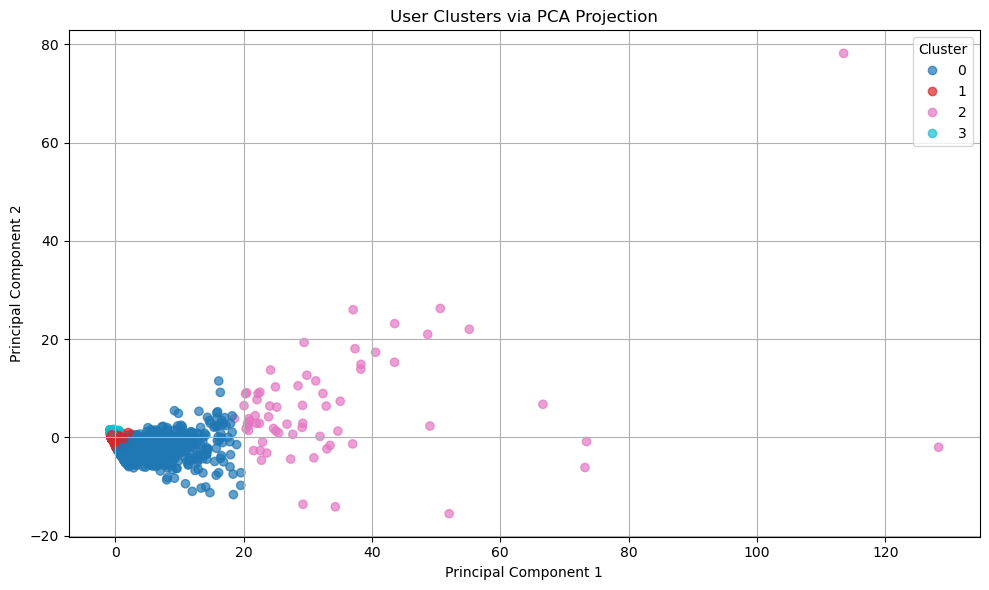

Cluster labels added to usa_user_summary:


,User-ID,persona_cluster
0,2,3.0
1,20,3.0
2,42,1.0
4,51,1.0
5,56,0.0


In [2711]:


# Step 1: Run KMeans with chosen number of clusters (e.g., 4)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_cluster)

# Step 2: Reduce dimensionality with PCA for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_cluster.toarray())  # Convert from sparse to dense

# Step 3: Create a DataFrame for plotting
pca_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Cluster': cluster_labels
})

# Step 4: Plot the clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Cluster'], cmap='tab10', alpha=0.7)
plt.title("User Clusters via PCA Projection")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.grid(True)
plt.savefig('images/userclustersviaPCA.png')
plt.tight_layout()

plt.show()

# Step 5: Attach clusters back to the user summary
# Create a DataFrame for merging
cluster_df = train_df[['User-ID']].copy()
cluster_df['persona_cluster'] = cluster_labels

# Merge back into the full user summary
usa_user_summary = usa_user_summary.merge(cluster_df, on='User-ID', how='left')

# Filter to only users with a persona_cluster assigned (i.e., non-null clusters)
clustered_users = usa_user_summary[usa_user_summary['persona_cluster'].notna()].copy()


# Preview the updated DataFrame
print("Cluster labels added to usa_user_summary:")
display(clustered_users[['User-ID', 'persona_cluster']].head())



In [2712]:
clustered_users['persona_cluster'].value_counts(dropna=False)


persona_cluster
1.0    14888
3.0     5421
0.0     2195
2.0       67
Name: count, dtype: int64

In [2713]:
clustered_users['persona_cluster'].value_counts(normalize=True, dropna=False).round(3)


persona_cluster
1.0    0.660
3.0    0.240
0.0    0.097
2.0    0.003
Name: proportion, dtype: float64

In [2717]:

score = silhouette_score(X_cluster, cluster_labels)
print(f"Silhouette Score: {score:.3f}")


Silhouette Score: 0.144


### Explore cluster profiles

In [2719]:


# # Step 1: Summary stats per cluster (numeric)
# cluster_profiles = clustered_users.groupby('persona_cluster').mean(numeric_only=True)
# numeric_summary = cluster_profiles[
#     ['Age', 'read_cnt', 'rated_high_cnt', 'rated_average', 'author_diversity', 'publisher_diversity']
# ].round(2)


# Step 1: Compute standard cluster profiles with all numeric data
cluster_profiles = clustered_users.groupby('persona_cluster').mean(numeric_only=True)

# Step 2: Recompute rated_average excluding 0s
rated_avg_filtered = (
    clustered_users[clustered_users['rated_average'] > 0]
    .groupby('persona_cluster')['rated_average']
    .mean()
)

# Step 3: Replace the column in the summary
cluster_profiles['rated_average'] = rated_avg_filtered

# Step 4: Slice and round as needed
numeric_summary = cluster_profiles[
    ['Age', 'read_cnt', 'rated_high_cnt', 'rated_average', 'author_diversity', 'publisher_diversity']
].round(2)


# Step 2: Most common favorite era per cluster (categorical)
fav_era_by_cluster = clustered_users.groupby('persona_cluster')[['fav_pub_era','favorite_author','mostread_book']].agg(
    lambda x: x.mode().iloc[0] if not x.mode().empty else "unknown"
)

# Step 3: Top title words (interest and favorite) per cluster
def top_cluster_words(series, n=10):
    # Define words to exclude
    exclude = {'<sep>', 'none'}
    all_words = ' '.join(series.dropna()).split()
    # Filter out excluded tokens
    filtered_words = [word for word in all_words if word not in exclude]
    # Return top n most common words
    return [word for word, _ in Counter(filtered_words).most_common(n)]

interest_words_by_cluster = clustered_users.groupby('persona_cluster')['interest_title_words'].apply(top_cluster_words)
fav_words_by_cluster = clustered_users.groupby('persona_cluster')['fav_title_words'].apply(top_cluster_words)

# Display all profiles together
print("🧠 Numeric Summary (Selected Features):")
display(numeric_summary)

print("\n📚 Most Common Favorite Era per Cluster:")
display(fav_era_by_cluster)

print("\n🔤 Top Interest Title Words per Cluster:")
display(interest_words_by_cluster)

print("\n❤️ Top Favorite Title Words per Cluster:")
display(fav_words_by_cluster)


🧠 Numeric Summary (Selected Features):


,Age,read_cnt,rated_high_cnt,rated_average,author_diversity,publisher_diversity
persona_cluster,,,,,,
0.0,36.31,100.95,20.82,7.79,0.70,0.54
1.0,38.04,4.98,1.64,7.78,0.98,0.96
2.0,39.09,1621.58,165.51,7.97,0.65,0.23
3.0,36.8,1.81,0.00,3.28,0.99,0.99



📚 Most Common Favorite Era per Cluster:


,fav_pub_era,favorite_author,mostread_book
persona_cluster,,,
0.0,1990s,Stephen King,1st to Die: A Novel
1.0,2000s,Dan Brown,A Painted House
2.0,1990s,Nora Roberts,1984
3.0,2000s,Rich Shapero,Wild Animus



🔤 Top Interest Title Words per Cluster:


persona_cluster
0.0         [mystery, life, love, romance, woman, guide, novel, time, world, story]
1.0          [life, mystery, guide, love, time, classic, world, story, club, woman]
2.0    [mystery, love, romance, life, woman, time, little, story, book, silhouette]
3.0       [life, mystery, love, wild, world, woman, novel, story, american, animus]
Name: interest_title_words, dtype: object


❤️ Top Favorite Title Words per Cluster:


persona_cluster
0.0    [life, mystery, guide, love, novel, world, time, secret, classic, story]
1.0      [life, classic, guide, club, mystery, time, world, love, woman, story]
2.0       [mystery, life, guide, classic, love, time, woman, world, tale, book]
3.0                                                                          []
Name: fav_title_words, dtype: object

In [2720]:
# Combine into one DataFrame for comparison
words_df = pd.DataFrame({
    '🔤 Interest Words': interest_words_by_cluster,
    '❤️ Favorite Words': fav_words_by_cluster
})

# Show full column width
pd.set_option('display.max_colwidth', None)

display(words_df)


,🔤 Interest Words,❤️ Favorite Words
persona_cluster,,
0.0,"[mystery, life, love, romance, woman, guide, novel, time, world, story]","[life, mystery, guide, love, novel, world, time, secret, classic, story]"
1.0,"[life, mystery, guide, love, time, classic, world, story, club, woman]","[life, classic, guide, club, mystery, time, world, love, woman, story]"
2.0,"[mystery, love, romance, life, woman, time, little, story, book, silhouette]","[mystery, life, guide, classic, love, time, woman, world, tale, book]"
3.0,"[life, mystery, love, wild, world, woman, novel, story, american, animus]",[]


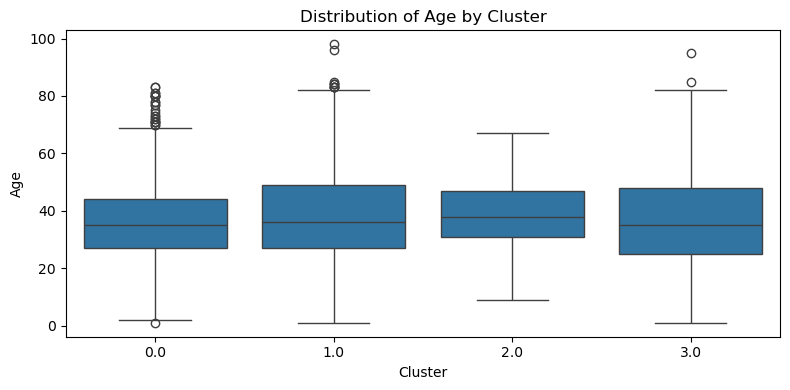

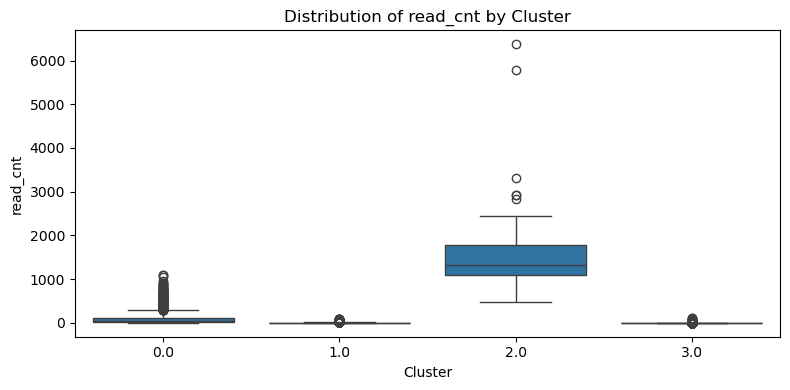

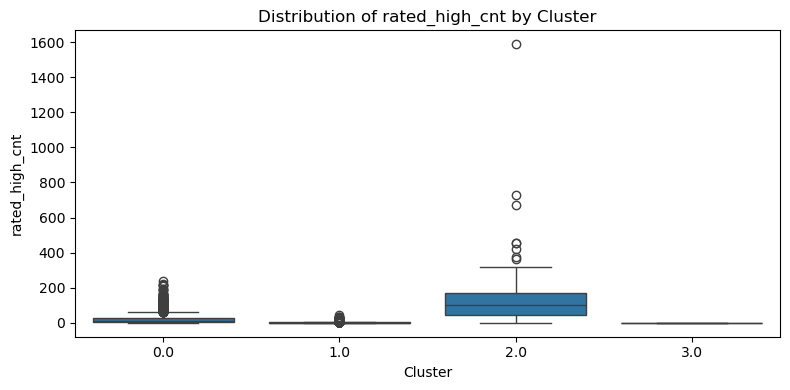

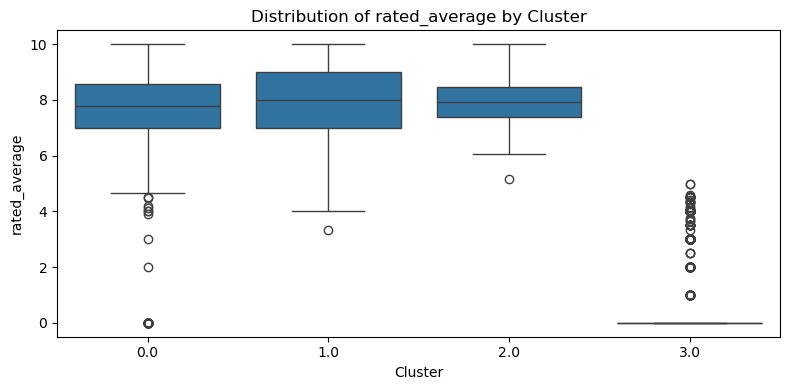

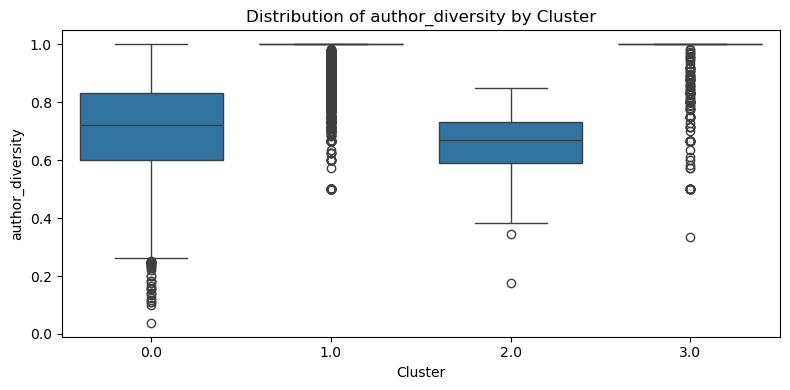

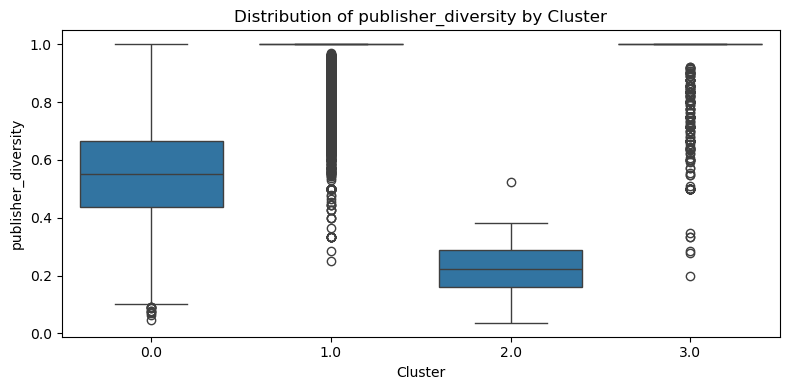

In [2721]:
# Plot
for feature in numeric_summary:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=clustered_users, x='persona_cluster', y=feature)
    plt.title(f'Distribution of {feature} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(feature)
    plt.tight_layout()
    plt.show()